<h1 align=center style="color:#000080;">The Secret to Reducing Health Care Costs: Predicting Health Insurance Claims with Artificial Intelligence</h1>
<h3 align=center style="color:#b30000;"> By Buhari Shehu</h3>
<div align=center style="color:#000080;"> shehubuhari1@gmail.com</div>

<img src="health_insurance.png" alt="insurance_claim_-image" style="width:1000px;height:500px;">

Photo created with [Canva](.)
<br>
.
<br>
.
<br>
.
<br>

<h2 style="color:#000080;"> Table of Contents </h2>
<ul>
<li><a href="#intro">1. Introduction</a></li>
<li><a href="#wrangling">2. Data Wrangling</a></li>
<li><a href="#eda">3. Exploratory Data Analysis</a></li>
<li><a href="#model">4. Model Selection and Evaluation</a></li>
<li><a href="#conclusions">5. Conclusions</a></li>
<li><a href="#references">6. References</a></li>
</ul>

<div id='intro'></div>

<h2 style="color:#000080;"> 1. Introduction </h2>

Insurance companies collect premiums from policyholders to cover the cost of claims and make profits. The companies may need more money to cover all of the claims that are filed if they fail to predict the cost of claims accurately. This can lead to financial losses for the insurance company, and it can also lead to policyholders being underinsured. Insurance claim analysis and prediction can also help insurance companies segment policyholders based on risk level, customise marketing strategies, enhance customer satisfaction and prevent fraud.
    
The goal of this project is to explore the insurance claim dataset from Kaggle and find out what influences the cost of claims made by policyholders. We will also use regression models to forecast future claims by the policyholders. The results of this project can help the insurance company to adjust the premiums and reduce expenses. The results can also inform the government about some of the main causes of health problems.

<h3 style="color:#b30000;"> 1.1 Dataset description</h3>

The dataset is publicly available on [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance). It consists of the following features:


Table 1.1: Dataset's features *(Lantz, 2013)*

| Feature | Description |
|--------|:-----------------|
| **`age`**        | This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government). |
| **`sex`**       | This is the policy holder's gender, either male or female. |
| **`bmi`**        | This is the body mass index (BMI), which provides a sense of how over or under-weight a person is relative to their height. BMI is equal to weight (in kilograms) divided by height (in meters) squared. An ideal BMI is within the range of 18.5 to 24.9. |
| **`children`**   | This is an integer indicating the number of children / dependents covered by the insurance plan. |
| **`smoker`**     | This is yes or no depending on whether the insured regularly smokes tobacco. |
| **`region`**     | This is the beneficiary's place of residence in the U.S., divided into four geographic regions: northeast, southeast, southwest, or northwest. |
|**`charges`**      |This is the individual's medical cost.|

<h3 style="color:#b30000;"> 1.2 Installing and importing dependencies</h3>    

The following packages are essential to running this project successfully: `numpy, pandas, matplotlib, seaborn, sklearn, and xgboost`.


In [ ]:
# importing data analysis libraries
import numpy as np
import pandas as pd

# importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# overriding matplotlib
sns.set()

# importing machine learning classes and functions
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

# importing warnings
import warnings
warnings.filterwarnings('ignore')

<h3 style="color:#b30000;"> 1.3 Loading the dataset</h3>    

In [128]:
# load the dataset
insurance_df = pd.read_csv('insurance.csv')
insurance_df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [129]:
insurance_df.tail(3)

,age,sex,bmi,children,smoker,region,charges
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


<div id='wrangling'></div>

<h2 style="color:#000080;"> 2. Data Wrangling </h2>

In this section, our primary focus will be to thoroughly examine the dataset for potential issues that could impact the accuracy and reliability of our analysis. We will carefully assess the data type discrepancies, identify any missing values, check entries duplication and flag potential outliers. Addressing these issues is crucial as they can significantly impact the validity of our conclusions.

**What is the size, data type and are there missing values in the dataset?**

In [ ]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset consists of **`1338 non-null entries`** distributed across seven features, with each feature assigned the appropriate data type.

**Are there duplicates in the dataset?**

In [ ]:
# count duplicates
"The dataset comprises {} duplicate(s).".format(insurance_df.duplicated().sum())

'The dataset comprises 1 duplicate(s).'

- ***Drop the duplicate and check***

In [130]:
insurance_df = insurance_df.drop_duplicates()
"The dataset now comprises {} duplicate(s) and {} non-null entries.".format(insurance_df.duplicated().sum(), insurance_df.shape[0])

'The dataset now comprises 0 duplicate(s) and 1337 non-null entries.'

**Are there outliers in the dataset?**

We will create two functions to identify the outliers.

In [ ]:
def find_outlier_rows(df, col, level='both'):
    """
  Finds the rows with outliers in a given column of a dataframe.

  This function takes a dataframe and a column as input, and returns the rows
  with outliers in the given column. Outliers are identified using the
  interquartile range (IQR) formula. The optional level parameter allows the
  caller to specify the level of outliers to return, i.e., lower, upper, or both.

  Args:
    df: The input dataframe.
    col: The name of the column to search for outliers.
    level: The level of outliers to return, i.e., 'lower', 'upper', or 'both'.
           Defaults to 'both'.

  Returns:
    A dataframe containing the rows with outliers in the given column.
  """
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

- ***find the outliers***

In [ ]:
def count_outliers(df):
    """
    Identify and count outliers in the numeric columns of a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing numeric columns.

    Returns:
    DataFrame: A DataFrame containing the count and percentage of outliers for each numeric column.
               The index contains the column names, and the DataFrame has two columns:
               'outlier_counts': Number of outliers found in each column.
               'outlier_percent': Percentage of outliers relative to the total entries in each column.
    """
    # select numeric columns
    df_numeric = df.select_dtypes(include=['int', 'float'])

    # get column names
    columns = df_numeric.columns

    # find the name of all columns with outliers
    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]

    # dataframe to store the results
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    # count the outliers and compute the percentage of outliers for each column
    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count*100/all_entries, 2)

    # store the results in the dataframe
    outliers_df.loc[col] = [outlier_count, outlier_percent]
    # return the resulting dataframe
    return outliers_df

In [ ]:
count_outliers(insurance_df)

,outlier_counts,outlier_percent
charges,139.0,10.4


**`Charges`** have outliers. Let's examine the outliers.

In [ ]:
charges_outliers_df = find_outlier_rows(insurance_df, "charges")
charges_outliers_df

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


Let's see the summary statistics of `charges_outliers_df`.

In [ ]:
charges_outliers_df.describe()

,age,bmi,children,charges
count,139.000000,139.000000,139.000000,139.000000
mean,41.079137,35.564604,1.187050,42103.947206
std,13.801420,4.434917,1.126546,5582.168107
min,18.000000,22.895000,0.000000,34617.840650
25%,30.000000,32.667500,0.000000,37786.149950
50%,43.000000,35.200000,1.000000,40974.164900
75%,52.500000,37.660000,2.000000,45786.706425
max,64.000000,52.580000,4.000000,63770.428010


- The **`charges`** outliers range from **`$34,617 - $63,770`**. Given that these values represent substantial costs to the insurance firm, they will be retained in the dataset without any alterations.

<div id='eda'></div>

<h2 style="color:#000080;"> 3. Exploratory Data Analysis & Feature Engineering</h2>

In this section, our aim is to thoroughly explore the dataset, uncovering patterns and insights that will serve as a guide for formulating meaningful questions and conducting in-depth analyses. To achieve this, we will also engineer new features and approach the dataset from multiple perspectives: univariate and multivariate.

<h3 style="color:#b30000;"> 3.1 Feature Engineering</h3>

In this sub-section, we will engineer new features to enable us to see the distribution and influence of **`BMI`** and **`age`** across various clusters.
Thus, **`age`** will be organized into clusters, each spanning a 10-year interval. Meanwhile, **`BMI`** will undergo clustering as per the criteria specified in Table 3.1.

Table 3.1: Body Mass Index categories [CDC](https://www.cdc.gov/healthyweight/assessing/index.html)
    
| BMI      | Weight Status |
|:----------- |:----------- |
| Below 18.5     | Underweight|
| 18.5—24.9  | Healthy Weight |
| 25.0—29.9     | Overweight  |
| 30.0 and Above  | Obesity   |

- ***Create bmi_category feature***

In [131]:
# Define categories
categories = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
thresholds = [18.5, 25, 30]
# Create a new column 'BMI Category' and map the values
insurance_df['bmi_category'] = pd.cut(insurance_df['bmi'], bins=[0] + thresholds + [float('inf')], labels=categories)

- ***Create age_range feature***

In [132]:
# Define age ranges and corresponding labels
age_ranges = [18, 30, 40, 50, 60, 70]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69']

# Create a new column 'age_range' with age ranges
insurance_df['age_range'] = pd.cut(insurance_df['age'], bins=age_ranges, labels=age_labels, right=False)

- ***Check***

In [ ]:
insurance_df.head(3)

,age,sex,bmi,children,smoker,region,charges,bmi_category,age_range
0,19,female,27.90,0,yes,southwest,16884.9240,Overweight,18-29
1,18,male,33.77,1,no,southeast,1725.5523,Obese,18-29
2,28,male,33.00,3,no,southeast,4449.4620,Obese,18-29


<h3 style="color:#b30000;"> 3.2 Univariate Analyses</h3>

In this sub-section, we will explore the summary statistics and distributions of the individual features.This exploration aims to uncover insights into the various factors that contribute to medical costs.

**What are the summary statistics of the dataset?**

In [ ]:
insurance_df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Based on the above summary statistics:

1. **`Age`** and **`charges`** exhibit high variability, indicating a wide range of values within these variables.

2. More than half of the policyholders are above **`39 years old`**, and all of them meet the necessary age requirements, with none below the legal age of **`18`** or having reached the retirement age of **`65 years`**.
We will compare the charges across different age groups to gain insights into the impact of age on insurance costs.

3. Over half of the policyholders are classified as obese **`(BMI > 30)`**, while a portion of them falls under the underweight category **`(BMI < 18.5)`**, showcasing diverse **`BMI`** distributions. It will be interesting to compare the charges across BMI categories.

4. Approximately half of the policyholders have one or no child, indicating diverse family sizes among the insured. 

5. The highest charge observed in the dataset is **`$63,770`**, representing the most significant insurance cost incurred by a policyholder.

These insights provide a valuable overview of the dataset, highlighting the demographic and cost-related characteristics of the policyholders.

Let us investigate the skweness of the numerical variables.

**Skweness**

In [ ]:
 insurance_df.skew()

age         0.054781
bmi         0.283914
children    0.937421
charges     1.515391
dtype: float64

- Based on the skewness values of less than 1 for **`age, BMI, and children`**, we can infer that these variables are approximately symmetrical. However **`charges`** with skewness greater than 1.5 are asymmetric, indicating a significant departure from symmetry. In such cases, the median charge of about **`$9,400`** is more appropriate than the mean in summarizing the variable.

**How are the variables distributed?**

To analyze the distributions of the dataset's features, we will create histograms for the numerical variables and bar plots for the categorical variables.

- ***Plot histograms for the numerical variables***

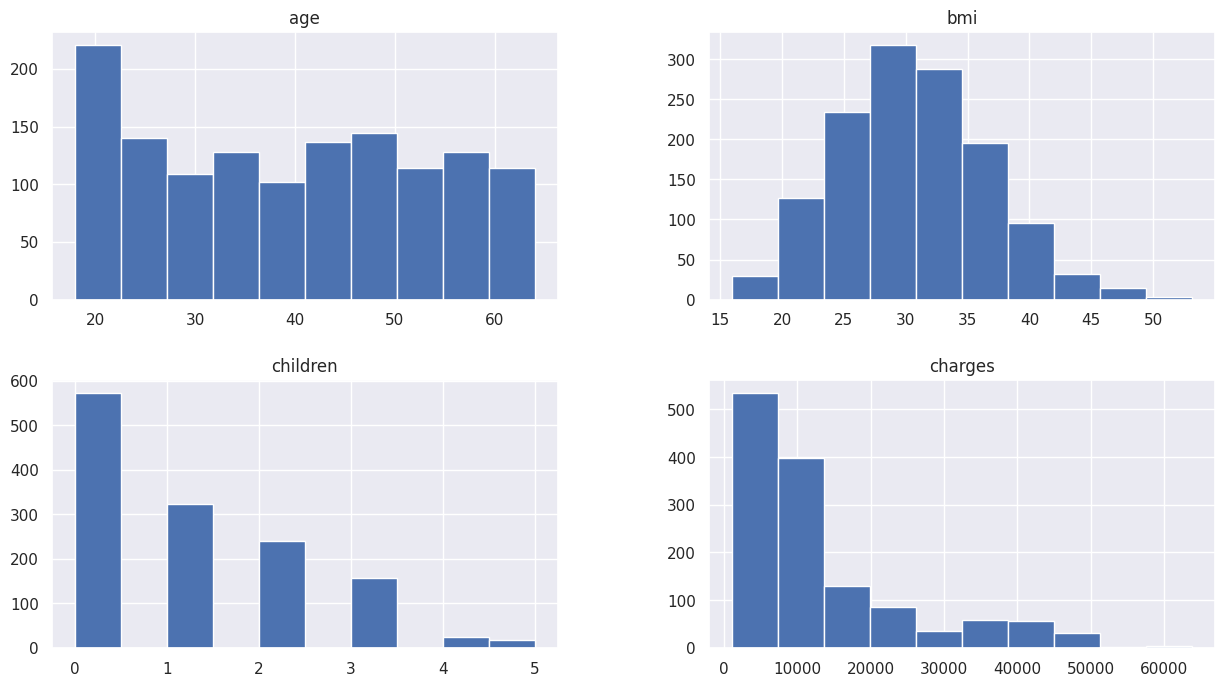

In [ ]:
# Select numerical features
numerical_df = insurance_df.select_dtypes(include=['int', 'float'])

# Plot histograms
numerical_df.hist(figsize=(15, 8));

The graphical representations reveal the following:
1. **`Age`** follows an approximately uniform distribution, with teenagers comprising the majority of policyholders.
2. **`BMI`** exhibits an approximately normal distribution.
3. The number of **`children`** and insurance **`charges`** both display right-skewed distributions.

- ***Plot the bar charts of the categorical features***

We will create a function to plot multiple bar charts.

In [ ]:
def plot_multiple_bar_charts(df):
    """
    Plots multiple bar charts to visualize the distribution of categorical variables in the DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing categorical variables.

    Returns:
        None
    """
    import matplotlib.pyplot as plt

    # Create subplots dynamically based on the number of datasets
    num_plots = len(df.columns)
    col = df.columns

    # Determine the number of rows and columns for subplots
    num_rows = 2
    num_cols = (num_plots + 1) // 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

    # Plot each dataset as a separate bar chart
    for i in range(num_plots):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].bar(df[col[i]].value_counts().index, df[col[i]].value_counts().values)
        axes[row_idx, col_idx].set_title(f'Distribution of {col[i]}')
        axes[row_idx, col_idx].set_ylabel('Count')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

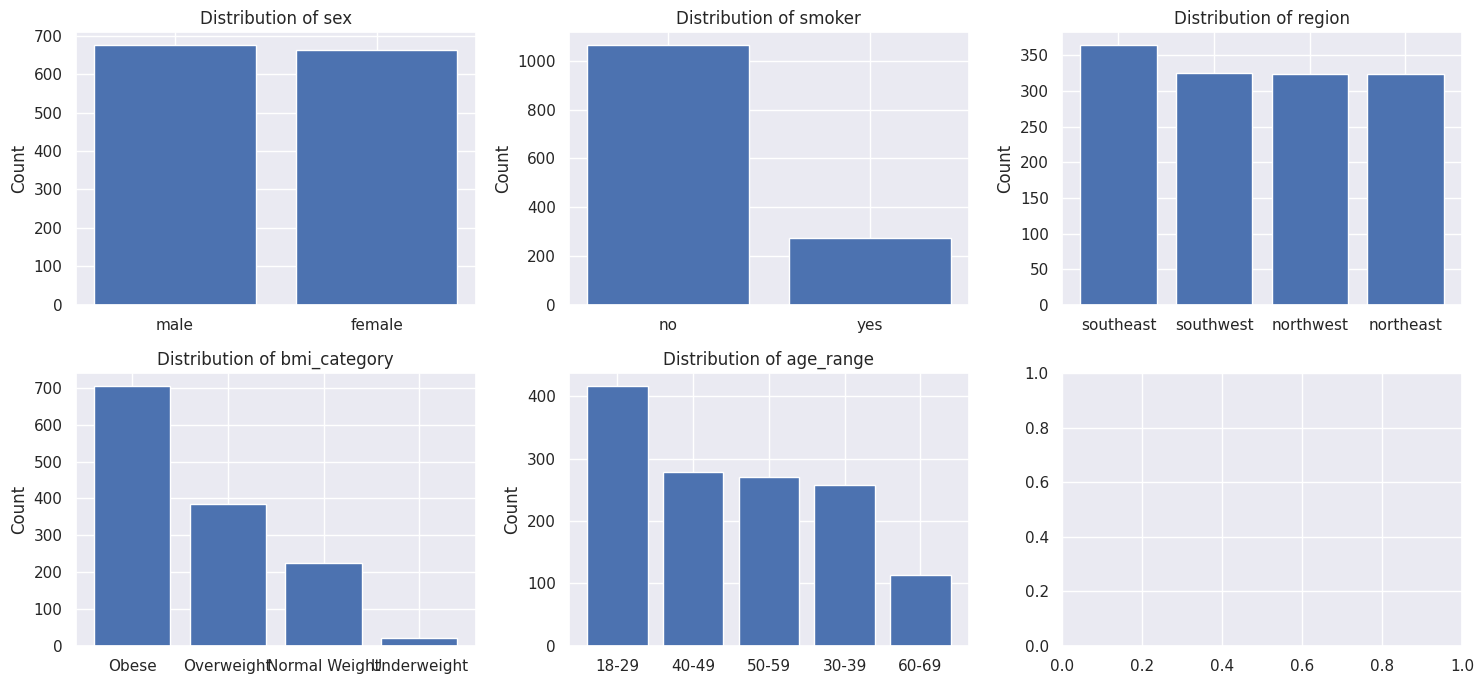

In [ ]:
# Select categorical features
categorical_df = insurance_df.select_dtypes(include=['object', 'category'])

# Call the function with the DataFrame
plot_multiple_bar_charts(categorical_df)


The bar charts provide the following insights:

1. Both males and females are distributed nearly evenly.
2. The **`majority`** of policyholders are **`non-smokers`**.
3. With the exception of the southeast region, where a single category prevails, the other regions are evenly distributed.
4. The **`majority`** of policyholders are categorized as **`obese or overweight`**, with a small proportion falling under the underweight category.
5. **`Teenagers`** form the largest group of policyholders, while the age ranges display a slightly right-skewed distribution.

<h3 style="color:#b30000;"> 3.3 Multivariate Analyses</h3>

In this sub-section, we will explore the interactions of features with the response variable. This exploration will play a pivotal role in enhancing our comprehension of the key features that hold significance in predicting medical charges.

- ***Check correlations***

In [ ]:
insurance_df.corr()

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


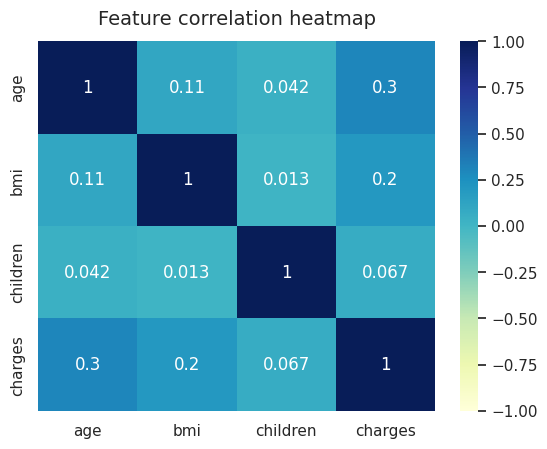

In [ ]:
heatmap = sns.heatmap(insurance_df.corr(), vmin=-1, vmax=1, annot=True, cmap ="YlGnBu")
heatmap.set_title('Feature correlation heatmap', fontdict={'fontsize':14}, pad=12);

As anticipated, both **`age and BMI`** exhibit a moderate positive correlation with charges, whereas the remaining features display relatively weak correlations with charges.

- ***Plot pair plots to visualise the correlations between features and the response variable***

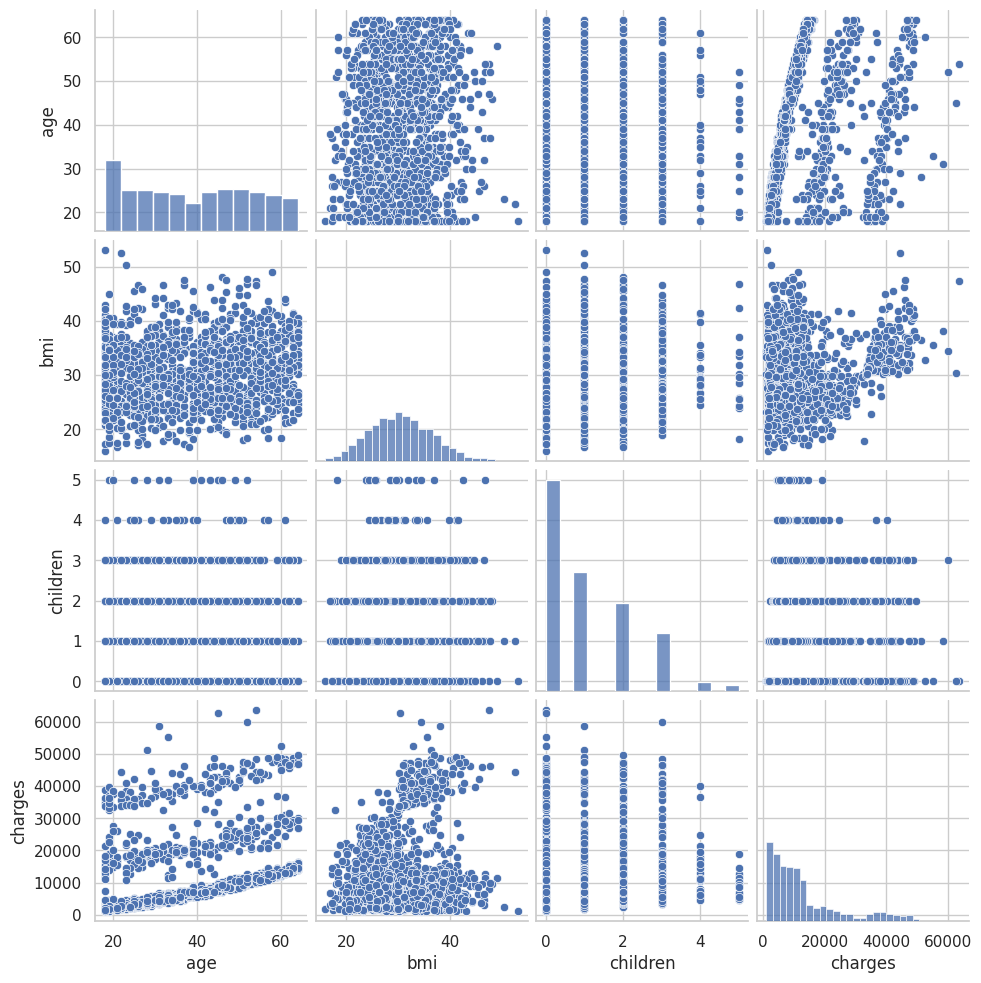

In [ ]:
# pair plot
sns.set_style("whitegrid");
sns.pairplot(insurance_df);
plt.show();

Similar to the heatmap, the scatter plots confirm the presence of a moderate correlation between **`age, BMI and charges`**. Additionally, the scatter plots reveal the existence of three distinct clusters in the relationship between **`age and charges`**. Further investigation is warranted to determine if another feature contributes to the formation of these clusters.

**How do charges differ based on BMI groups?**

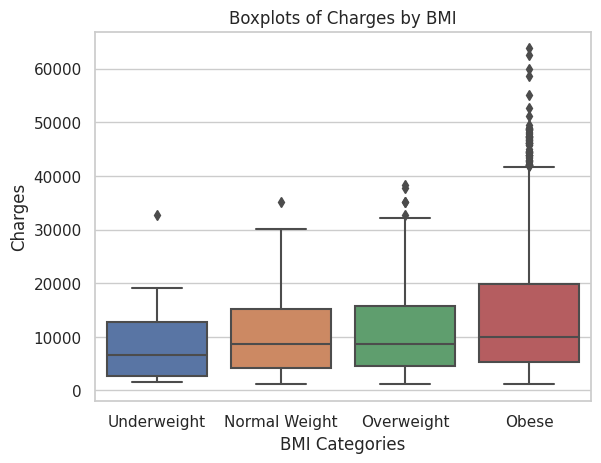

In [ ]:
# Plot multiple boxplots
sns.boxplot(x='bmi_category', y='charges', data=insurance_df)

# Add labels and title
plt.xlabel('BMI Categories')
plt.ylabel('Charges')
plt.title('Boxplots of Charges by BMI')

# Show the plot
plt.show()

The box plot shows that the median charge is higher for people who are obese than for people who are normal weight or underweight. The interquartile range is also wider for people who are obese, which indicates that there is more variation in the charges for people who are obese. There are also a few outliers for people who are obese, which indicates that there are some people who have very high charges.

This box plot suggests that there is a positive association between **`BMI`** and **`charges`**. This means that people who are obese tend to have higher medical charges than people who are normal weight or underweight. This association may be due to a number of factors, such as the fact that obese people are more likely to have chronic diseases that require medical care.

**How does charges differ by number of children?**

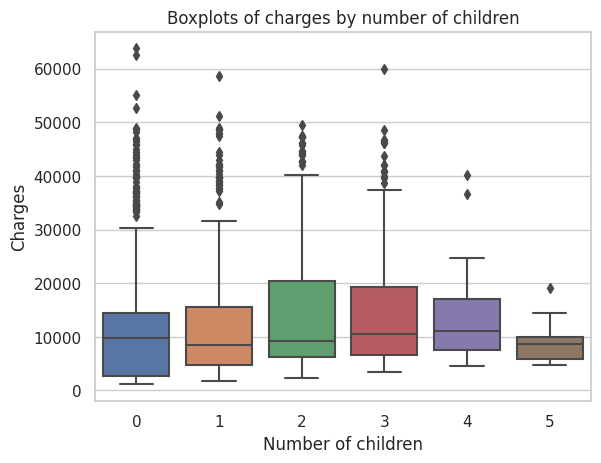

In [ ]:
# Plotting multiple boxplots
sns.boxplot(x='children', y='charges', data=insurance_df)

# Adding labels and title
plt.xlabel('Number of children')
plt.ylabel('Charges')
plt.title('Boxplots of charges by number of children')

# Show the plot
plt.show()

The box plot analysis reveals intriguing insights: individuals without children surprisingly exhibit both the highest medical charges and the greatest variability in charges. This contradicts the common assumption that more children equate to higher medical costs. Generally, it can be concluded that the number of children doesn't exert a substantial influence on medical charges, as indicated by the closely aligned box plots. Notably, the only notable deviation from this trend emerges in the box plot representing individuals with 5 children.

**How does charges vary by age groups?**

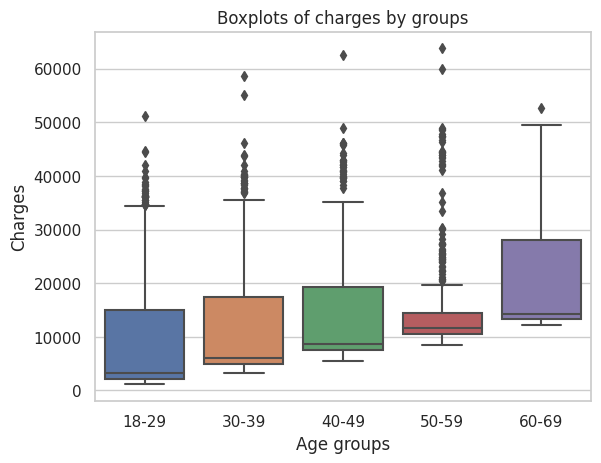

In [ ]:
# Plotting multiple boxplots
sns.boxplot(x='age_range', y='charges', data=insurance_df)

# Adding labels and title
plt.xlabel('Age groups')
plt.ylabel('Charges')
plt.title('Boxplots of charges by groups')

# Show the plot
plt.show()

it's important to emphasize the observable trend of medical expenses gradually rising with age. This trend holds true even though teenagers make up the majority of the dataset. Notably, the **`60-69 age group`** stands out, exhibiting the highest cumulative charges.

**How does BMI and smoking status affect charges?**

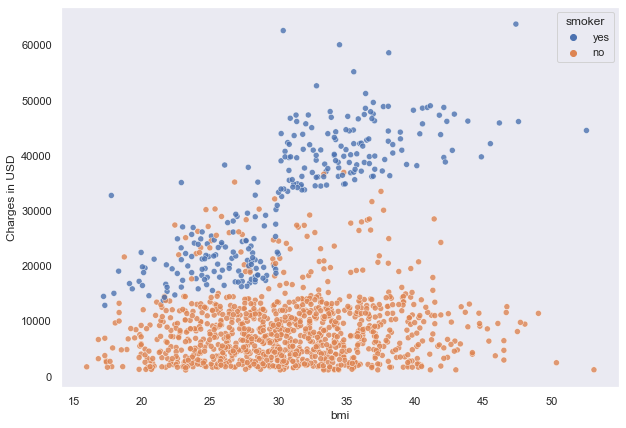

In [147]:
# scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x="bmi",
                y="charges",
                sizes=(20, 100),
                alpha=0.8,
                hue="smoker",
                data=insurance_df)

# Remove grid lines
plt.grid(False)
plt.ylabel("Charges in USD")
plt.show()

It's evident that **`charges`** some what increases with **`bmi`** and smokers have higher medical costs compared to non-smokers, despite constituting a minority among policyholders. This correlation might be attributed to the heightened likelihood of smokers developing diseases such as lung cancer, which could drive up their healthcare expenses.

**How does age and smoking status affect charges?**

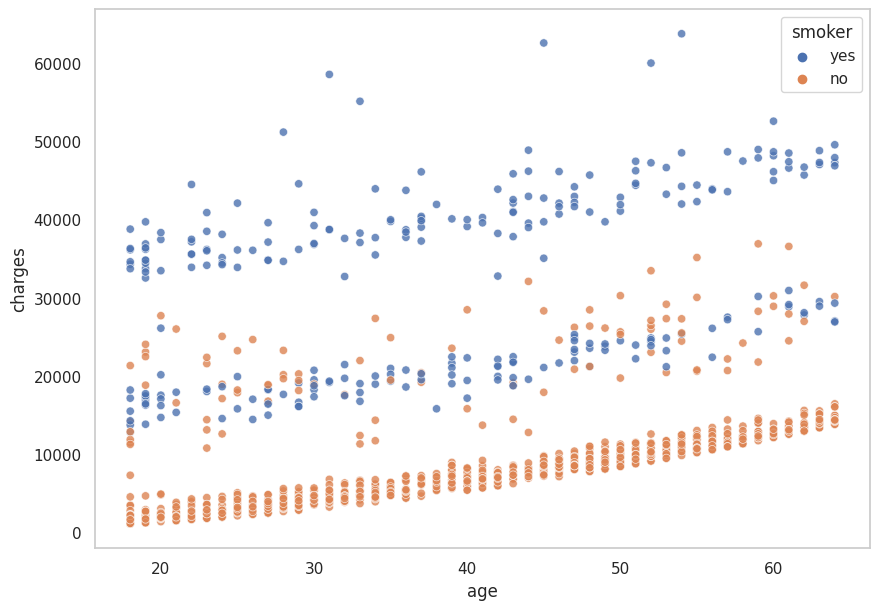

In [ ]:
# scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x="age",
                y="charges",
                sizes=(20, 100),
                alpha=0.8,
                hue="smoker",
                data=insurance_df)

# Remove grid lines
plt.grid(False)

plt.show()

It can be observed that **`charges`** increases with **`age`**. The plot also illustrates that the smoking status clarifies the presence of what initially appeared as three clusters, revealing that there are, in fact, two clusters with a degree of overlap between smokers and non-smokers within the middle cluster.

<div id='model'></div>

<h2 style="color:#000080;"> 4. Model Selection and Evaluation </h2>

In this section, our focus will be on training a range of regression models, followed by their evaluation and the subsequent selection of the optimal model for predicting medical charges.

In [133]:
# make a copy of the dataset
insurance_df_copy = insurance_df.copy()

In [134]:
# get the features set and the response variable
X = insurance_df_copy.drop("charges", axis=1)
y = insurance_df_copy["charges"]

- ***Convert categorical features to dummy numerical features***

In [135]:
X = pd.get_dummies(X, drop_first=True)

- ***Instantiate various regressors***

In [ ]:
# Create a dictionary of regressor models
regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(random_state=0),
    "XGBoost": xg.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

}

- ***Create a function to evaluate the regressors***

In [ ]:
def evaluate_regressors(regressors, X, y, cv=5, scoring=('r2', 'neg_root_mean_squared_error')):
    """
    Function to train and evaluate multiple regression models using cross-validation.

    Parameters:
        - regressors: Dictionary of regression model objects with model names as keys.
        - X: Feature matrix or input data.
        - y: Target variable or output data.
        - cv: Number of cross-validation folds (optional, default=5).
        - scoring: Scoring metric(s) to use during cross-validation (optional, default=('r2', 'neg_root_mean_squared_error')).

    Returns:
        - scores_df: Pandas DataFrame containing the model names, mean R-squared scores, and mean RMSE scores.
    """

    # Dictionary to store the scores
    scores = {'Model': [], 'Mean R-squared': [], 'Mean RMSE': []}

    # Iterate through the regressors dictionary
    for model_name, regressor in regressors.items():
        # Perform cross-validation
        cv_results = cross_validate(regressor, X, y, cv=cv, scoring=scoring)

        # Extract R-squared scores and calculate mean
        r2_scores = cv_results['test_r2']
        mean_r2 = np.mean(r2_scores)

        # Extract RMSE scores and calculate mean
        rmse_scores = -cv_results['test_neg_root_mean_squared_error']
        mean_rmse = np.mean(rmse_scores)

        # Store the scores in the dictionary
        scores['Model'].append(model_name)
        scores['Mean R-squared'].append(mean_r2)
        scores['Mean RMSE'].append(mean_rmse)

    # Create a DataFrame from the scores
    scores_df = pd.DataFrame(scores)

    # Sort the DataFrame in descending order by mean R-squared
    scores_df.sort_values(by='Mean R-squared', ascending=False, inplace=True)

    # Reset the index of the DataFrame
    scores_df.reset_index(drop=True, inplace=True)

    return scores_df

- ***Evaluate the regressors***

In [ ]:
scores_df = evaluate_regressors(regressors, X, y)
scores_df

,Model,Mean R-squared,Mean RMSE
0,Random Forest,0.837876,4840.448234
1,XGBoost,0.807184,5271.917409
2,Ridge,0.752494,6006.440824
3,Lasso,0.752357,6008.006837
4,Linear Regression,0.752341,6008.199608
5,Elastic Net,0.390834,9442.093211


Based on the evaluation provided in the table above, the Random Forest regressor demonstrated superior performance compared to other regressors. The **`R-sqaured`** metric of the model is 0.8378. This signifies that around **`83.78%`** of the variability in the charges can be elucidated by the features integrated within the regression model. In simpler terms, the model adeptly captures and clarifies a significant portion of the variance present in the data.

Furthermore, the **`RMSE`** of **`$4,840`** emphasizes that, on average, the predictions produced by the Random Forest model have an error of about **`$4,800`** when estimating medical charges. This represents a **`40% error`** in relation to the interquartile range, which is **`$11,911`**. This comparison sheds light on the magnitude of the prediction error relative to the variability in the data.

<div id='conclusions'></div>

<h2 style="color:#000080;"> 5. Conclusions and recommendations</h2>


<h3 style="color:#b30000;"> 5.1 Conclusions</h3>

1. **BMI Distribution:**
   - Over half of the policyholders are classified as obese (BMI > 30), while a portion falls under the underweight category (BMI < 18.5), showcasing diverse BMI distributions.

2. **Highest Charge:**
   - The dataset's highest charge is $63,770, representing the most significant insurance cost incurred by a policyholder.

3. **Smoking Status:**
   - The majority of policyholders are non-smokers.

4. **Age Groups:**
   - Teenagers form the largest group of policyholders.
   - More than half of the policyholders are above 39 years old.

5. **BMI and Charges:**
   - Both age and BMI exhibit a moderate positive correlation with charges.
   - This box plot suggests a positive association between BMI and charges. Obese individuals tend to have higher medical charges due to potential chronic diseases.

6. **Number of Children:**
   - Generally, the number of children doesn't exert a substantial influence on medical charges, as indicated by closely aligned box plots.

7. **Smokers vs. Non-Smokers:**
   - Smokers have higher medical costs compared to non-smokers, despite being a minority among policyholders.
   - This correlation might be attributed to the heightened likelihood of smokers developing diseases such as lung cancer, driving up healthcare expenses.
   

<h3 style="color:#b30000;"> 5.2 Recommendations </h3>

1. Given the diverse BMI distributions, consider designing insurance plans that account for the health risks associated with various BMI categories. Tailoring coverage and incentives based on BMI-related health considerations could provide added value to policyholders.

2. Since the highest charge observed is substantial, it's essential to ensure that insurance plans adequately cover such significant costs. Offering flexible coverage options and comprehensive policies can provide peace of mind to policyholders in case of unforeseen medical expenses.

3. Address the higher medical costs associated with smoking by offering specialized plans or benefits tailored to smokers, such as coverage for cessation programs and preventive measures. Promote the long-term health and financial benefits of quitting smoking to policyholders. This can also lead to improved overall health.

4. Tailor marketing and communication strategies to address the needs and concerns of both teenagers and the middle-aged population. Highlight benefits that cater to the specific age groups, such as coverage for young adults' routine check-ups and health screenings or comprehensive plans for those approaching retirement.

5. Encourage policyholders, especially the obese, to adopt healthier lifestyles by offering wellness programs, discounts on gym memberships, and incentives for maintaining a healthy weight. This approach can contribute to overall well-being and potentially lower healthcare costs.


<div id='references'></div>

<h2 style="color:#000080;"> 6. References </h2>

1. Lantz, B. (2013). Machine Learning with R. Packt Publishing Ltd.
2. Centres for Disease Prevention and Control https://www.cdc.gov/healthyweight/assessing/index.html
3. Kaggle https://www.kaggle.com/datasets/mirichoi0218/insurance

Let's connect
- Github repo: https://github.com/BuhariS/insurance_claim_prediction
- https://www.linkedin.com/in/buhari-shehu/
- shehubuhari1@gmail.com